In [ ]:
# default_exp core2

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export 
from fastai.vision.all import *
import albumentations as A
import skimage.io as skio
import warnings
import tqdm
from collections import defaultdict
warnings.filterwarnings("ignore")

In [ ]:
imgs=get_files('/home/staff/xin/Downloads/tianchi/train/',extensions='.tif')

In [ ]:
df=pd.DataFrame({'path':imgs})

In [ ]:
#export

means=[0.1902, 0.2353, 0.2218, 0.5273,0.4712]
stds=[0.1248, 0.1203, 0.1165, 0.1968,0.2617]


In [ ]:
a=np.ones((256,256,3))
b=np.ones((256,256))

In [ ]:
np.expand_dims(b,2).shape

(256, 256, 1)

In [ ]:
.shape

(256, 256, 4)

In [ ]:
#export
def open_img(fn,cls=torch.Tensor):
    temp = skio.imread(fn)
#     print(temp.shape)
    temp=temp/255
    ndvi=(temp[:,:,-1]-temp[:,:,0])/(temp[:,:,-1]+temp[:,:,0])
    temp=np.concatenate((temp,np.expand_dims(ndvi,2)),axis=2)
#     temp=(temp-mins)/maxs
    return cls(temp)


class RsImage(TensorBase):

    @classmethod
    def create(cls, data:(Path,str,ndarray)):
        
        if isinstance(data, Path) or isinstance(data, str):    
            im = open_img(fn=str(data),cls=torch.Tensor)
        elif isinstance(data, ndarray): 
            im = torch.from_numpy(data)
        else:
            im = data
            
        return cls(im)

    
    def show(self,ctx=None):
        
        plt.imshow(self[:,:,0:3]) if ctx is None else ctx.imshow(self[:,:,0:3])
        
        return ctx
    
#     def __repr__(self):
        
#         return (f'SarTensorImage: {self.shape}')
    

class RsMask(TensorBase):

    @classmethod
    def create(cls, data:(Path,str,ndarray)):
        
        if isinstance(data, Path) or isinstance(data, str):
            im = skio.imread(str(data).replace('tif','png'))-1

        elif isinstance(data, ndarray): 
            im = torch.from_numpy(data)
        else:
            im = data
        
        return cls(im)

    
    def show(self,ctx=None):
        
        plt.imshow(self) if ctx is None else ctx.imshow(self)
        
        return ctx
    
#     def __repr__(self):
        
#         return (f'SarTensorMask: {self.shape}')

In [ ]:
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RsImage.create)),
                       TransformBlock(type_tfms=partial(RsMask.create)),
                      ),
               get_items=ColReader('path'),
               splitter=RandomSplitter(valid_pct=0)
              )

# db.summary(source=df)

In [ ]:
ds = db.datasets(source=df)

In [ ]:
classes=['farmland','forest','grass','road','urban','countryside','indust','construction','water','bareland']

<AxesSubplot:>

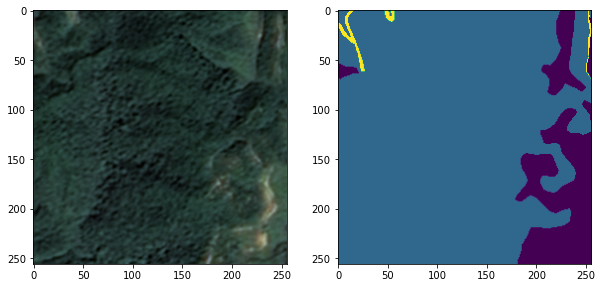

In [ ]:
ds = db.datasets(source=df)

idx = 30
img = ds.train[idx][0]
msk = ds.train[idx][1]

_, ax = plt.subplots(1, 2, figsize=(10, 5))
img.show(ctx=ax[0])
msk.show(ctx=ax[1])

In [ ]:
#export 
@typedispatch
def show_batch(x, y,figsize=None, **kwargs):
    _,axs = plt.subplots(len(x),2,figsize=(5,10))
    for i in range(len(x)):
        axs[i,0].set_axis_off()
        axs[i,1].set_axis_off()      
        RsImage(x[i]).show(ctx=axs[i,0])
        RsMask(y[i]).show(ctx=axs[i,1])
        
@typedispatch
def show_results(x, y, samples,figsize=None, **kwargs):
    _,axs = plt.subplots(len(x),2,figsize=(10,10))
    for i in range(len(x)):       
        RsMask(y[i]).show(ctx=axs[i,0])
        RsImage(x[i]).show(ctx=axs[i,1])
        

In [ ]:
dls = db.dataloaders(source=df, bs=20, num_workers=4)
# dls.show_batch??

In [ ]:
# mean = torch.zeros(1).cuda()
# std = torch.zeros(1).cuda()
# for inputs, _labels in tqdm.tqdm(dls.train):
#         temp=(inputs[:,:,:,-1]-inputs[:,:,:,0])/(inputs[:,:,:,-1]+inputs[:,:,:,0])
#         mean += temp.mean()
#         std += temp.std()
# mean.div_(len(dls.train))
# std.div_(len(dls.train))
# print(mean, std)


100%|██████████| 800/800 [00:17<00:00, 44.46it/s]


RsImage([0.4712], device='cuda:0') RsImage([0.2617], device='cuda:0')


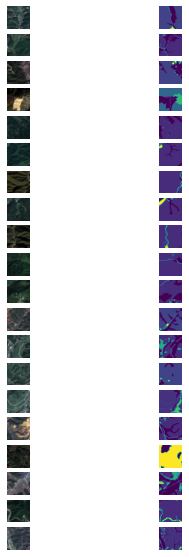

In [ ]:
dls.show_batch()

In [ ]:
#export 
# Now we will create a pipe of transformations
from albumentations.pytorch import ToTensorV2
aug_pipe = A.Compose([A.ShiftScaleRotate(p=.5),
                      A.HorizontalFlip(),
                      A.RandomBrightnessContrast(),
                      A.Normalize(mean=means,std=stds,max_pixel_value=1.0),
                         ToTensorV2()]                    
                    )
val_pipe = A.Compose([A.Normalize(mean=means,std=stds,max_pixel_value=1.0),
                         ToTensorV2()]                    
                    )

class TrainTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug,split=0): 
        self.aug = aug
#         self.split_idx = split
    def encodes(self, x):
        aug = self.aug(image=x[0].numpy(),mask=x[1].numpy())
#         print(torch.cat((aug['image0'],aug['image1']),axis=0).shape)
        return RsImage(aug['image']), RsMask(aug['mask'])
class ValTransform(ItemTransform):
    split_idx = 1
    def __init__(self, aug,split=0): 
        self.aug = aug
#         self.split_idx = split
    def encodes(self, x):
        aug = self.aug(image=x[0].numpy(),mask=x[1].numpy())
#         print(torch.cat((aug['image0'],aug['image1']),axis=0).shape)
        return RsImage(aug['image']), RsMask(aug['mask'])

# Create our class with this aug_pipe
aug = TrainTransform(aug_pipe)
aug2=ValTransform(val_pipe)

In [ ]:
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RsImage.create)),
                       TransformBlock(type_tfms=partial(RsMask.create)),
                      ),
               get_items=ColReader('path'),
               splitter=RandomSplitter(valid_pct=0.1),
               item_tfms=[aug,aug2]
#                batch_tfms=transforms.Normalize(means,stds)
              )

# db.summary(source=df)

In [ ]:
dls = db.dataloaders(source=df,bs=4, num_workers=0)
# dls.show_batch??

In [ ]:
aa,bb=first(dls.valid)

In [ ]:
from nbdev.export import notebook2script


In [ ]:
notebook2script(fname='./00_core2.ipynb')

Converted 00_core2.ipynb.
